In [51]:
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for pkg, mod in [
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("pandas", "pandas"),
    ("scikit-learn", "sklearn"),
    ("seaborn", "seaborn"),
    ("joblib", "joblib"),
]:
    install_if_missing(pkg)

# Librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle
import joblib
from sklearn.preprocessing import LabelEncoder

In [52]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Seaborn version:", sns.__version__)
print("Joblib version:", joblib.__version__)

NumPy version: 2.0.2
Pandas version: 2.2.2
Scikit-learn version: 1.7.0
Seaborn version: 0.13.2
Joblib version: 1.5.1


In [53]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [54]:
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [55]:
def get_numeric_and_categorical_columns(df, numeric_as_category = None):
    """
    Distingue entre columnas numéricas y categóricas de un DataFrame,
    permitiendo especificar columnas numéricas que deben tratarse como categóricas.

    Parámetros:
        df (pd.DataFrame): El DataFrame a analizar.
        numeric_as_category (list, opcional): Lista de columnas numéricas a tratar como categóricas.

    Returns:
        tuple: (lista de columnas numéricas, lista de columnas categóricas)
    """
    if numeric_as_category is None:
        numeric_as_category = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(numeric_as_category).tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.union(numeric_as_category).tolist()
    return numeric_cols, categorical_cols

In [56]:
def desglose_fechas(df, columna_fecha, tipo, sufijo):
    """
    Agrega una columna al DataFrame con el nombre del día o del mes extraído de una columna de fechas.

    Parámetros:
        df (pd.DataFrame): El DataFrame a modificar.
        columna_fecha (str): Nombre de la columna de tipo datetime.
        sufijo (str): Sufijo para la nueva columna (ej. 'reservacion', 'entrada', etc).
        tipo (str): 'dia' para día de la semana, 'mes' para mes. Default: 'dia'.
    """
    if columna_fecha not in df.columns:
        print(f"La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    if tipo == 'dia':
        df[f'dia_{sufijo}'] = df[columna_fecha].dt.day_name()
    elif tipo == 'mes':
        df[f'mes_{sufijo}'] = df[columna_fecha].dt.month_name()
    else:
        print("El parámetro 'tipo' debe ser 'dia' o 'mes'.")


In [57]:
# Cargar data
df = pd.read_csv('df_gmm.csv')
df.shape
# Columnas a utilizar
#df = df[['ID_Paquete', 'h_can_res', 'h_res_fec', 'h_num_adu', 'h_num_noc', 'ID_Tipo_Habitacion', 'cluster_gmm']] # 'h_fec_lld',

(88089, 27)

In [58]:
df = df[['h_res_fec', 'h_fec_lld', 'h_num_adu', 'h_num_men', 'h_num_noc', 'ID_Tipo_Habitacion', 'ID_Paquete', 'h_can_res', 'cluster_gmm']]

In [59]:
df['h_res_fec'] = pd.to_datetime(df['h_res_fec'])
df['h_fec_lld'] = pd.to_datetime(df['h_fec_lld'])
df['ID_Tipo_Habitacion'] = df['ID_Tipo_Habitacion'].replace('Otro', '0')
df['h_can_res'] = df['h_can_res'].replace('DI', '05')

In [60]:
desglose_fechas(df, 'h_res_fec', 'dia', 'reservacion')
desglose_fechas(df, 'h_fec_lld', 'dia', 'entrada')
desglose_fechas(df, 'h_res_fec', 'mes', 'reservacion')
desglose_fechas(df, 'h_fec_lld', 'mes', 'entrada')
df.drop(columns=['h_res_fec', 'h_fec_lld'], inplace=True)

In [61]:
# Preparación: Variables cíclicas
# Ciclicidad de días de la semana
day_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

df['dia_reservacion'] = df['dia_reservacion'].map(day_map).astype(int)
df['dia_entrada'] = df['dia_entrada'].map(day_map).astype(int)


# Ciclicidad de meses del año
mes_map = {
    'January': 0, 'February': 1, 'March': 2, 'April': 3,
    'May': 4, 'June': 5, 'July': 6, 'August': 7,
    'September': 8, 'October': 9, 'November': 10, 'December': 11
}

df['mes_reservacion'] = df['mes_reservacion'].map(mes_map)
df['mes_entrada'] = df['mes_entrada'].map(mes_map)

In [62]:
numerical_cols, categorical_cols = get_numeric_and_categorical_columns(df, numeric_as_category=['ID_Paquete', 'cluster_gmm', 'mes_entrada', 'mes_reservacion', 'dia_entrada', 'dia_reservacion'])

In [63]:
numerical_cols, categorical_cols

(['h_num_adu', 'h_num_men', 'h_num_noc'],
 ['ID_Paquete',
  'ID_Tipo_Habitacion',
  'cluster_gmm',
  'dia_entrada',
  'dia_reservacion',
  'h_can_res',
  'mes_entrada',
  'mes_reservacion'])

In [64]:
df = df[numerical_cols + categorical_cols]

In [65]:
# Cardinalidad

import pandas as pd
# Obtener los 2 valores más frecuentes para 'ID_Tipo_Habitacion'
top2_habitacion = df['ID_Tipo_Habitacion'].value_counts().nlargest(2).index.tolist()

# Reemplazar los valores que no están en top2 con 'Otro_Habitacion'
df['ID_Tipo_Habitacion'] = df['ID_Tipo_Habitacion'].apply(lambda x: x if x in top2_habitacion else 'Otro_Habitacion')

# Convertir 'h_can_res' a numérico para poder encontrar los 2 valores más frecuentes numéricamente
df['h_can_res_numeric'] = pd.to_numeric(df['h_can_res'], errors='coerce')

# Obtener los 2 valores más frecuentes para 'h_can_res' (usando la columna numérica)
top2_res = df['h_can_res_numeric'].dropna().value_counts().nlargest(2).index.tolist()

# Convertir los valores numéricos de top2_res de vuelta a string para compararlos con la columna original 'h_can_res'
top2_res_str = [str(int(x)) for x in top2_res]

# Reemplazar los valores en 'h_can_res' que no están en top2 con 'Otro_Res'
df['h_can_res'] = df['h_can_res'].apply(lambda x: x if str(x) in top2_res_str else 'Otro_Res')

# Eliminar la columna temporal numérica
df.drop(columns=['h_can_res_numeric'], inplace=True)

# Actualizar las listas de columnas numéricas y categóricas después de la modificación
numerical_cols, categorical_cols = get_numeric_and_categorical_columns(df, numeric_as_category=['ID_Paquete', 'cluster_gmm', 'mes_entrada', 'mes_reservacion', 'dia_entrada', 'dia_reservacion', 'ID_Tipo_Habitacion', 'h_can_res'])
numerical_cols, categorical_cols
df = df[numerical_cols + categorical_cols]
df.dtypes

,0
h_num_adu,int64
h_num_men,int64
h_num_noc,int64
ID_Paquete,int64
ID_Tipo_Habitacion,object
cluster_gmm,int64
dia_entrada,int64
dia_reservacion,int64
h_can_res,object
mes_entrada,int64


# SVM

In [66]:
df.head(1)

,h_num_adu,h_num_men,h_num_noc,ID_Paquete,ID_Tipo_Habitacion,cluster_gmm,dia_entrada,dia_reservacion,h_can_res,mes_entrada,mes_reservacion
0,2,0,3,1,Otro_Habitacion,2,3,4,Otro_Res,10,7


In [67]:
df.dtypes

,0
h_num_adu,int64
h_num_men,int64
h_num_noc,int64
ID_Paquete,int64
ID_Tipo_Habitacion,object
cluster_gmm,int64
dia_entrada,int64
dia_reservacion,int64
h_can_res,object
mes_entrada,int64


In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Separar variables predictoras y etiquetas
X = df.drop(columns=['cluster_gmm'])
y = df['cluster_gmm']

# Preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['h_num_adu', 'h_num_men', 'h_num_noc']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['ID_Paquete', 'dia_entrada', 'dia_reservacion', 'mes_entrada', 'mes_reservacion', 'ID_Tipo_Habitacion', 'h_can_res'])
])

# Modelo SVM
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo'))
])

# División del conjunto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2442
           1       0.93      0.91      0.92      1371
           2       1.00      1.00      1.00     13034
           3       1.00      1.00      1.00       771

    accuracy                           0.99     17618
   macro avg       0.97      0.97      0.97     17618
weighted avg       0.99      0.99      0.99     17618



In [69]:
joblib.dump(model, 'svm_model.pkl')

['svm_model.pkl']

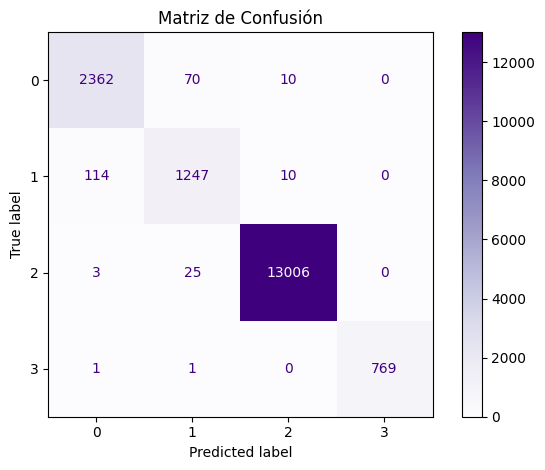

In [70]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Matriz de Confusión")
plt.grid(False)
plt.tight_layout()
plt.show()